In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_tokenizer_and_model(model="microsoft/phi-2"):
    """
    Load tokenizer and model instance for some specific Phi-2 model.
    """
    # Initialize tokenizer and model
    print("Loading model...")
    tokenizer = AutoTokenizer.from_pretrained(model, padding_side='left')
    model = AutoModelForCausalLM.from_pretrained(model)
    
    # Return tokenizer and model
    return tokenizer, model

In [4]:
from intel_extension_for_pytorch.quantization import prepare, convert
import intel_extension_for_pytorch as ipex

def quantize_model(tokenizer, model):
    """
    Adding IPEX dynamic quantization to the model
    """
    # Evaluate model
    model.eval()
    
    print("Quantization in progress...")
    
    # Prepare example outputs for the model
    question, text = "What is SYCL?", "SYCL is an industry-driven standard, developed by Kronos Group and announced in March 2014."
    inputs = tokenizer(question, text, return_tensors="pt")
    jit_inputs  = tuple((inputs['input_ids']))
    
    # Create configuration for dynamic quantization
    qconfig = ipex.quantization.default_dynamic_qconfig
    
    # Optimize model
    model = ipex.optimize(model)
    
    # Prepare model for quantization using previously prepared parameters
    prepared_model = prepare(model, qconfig, example_inputs=jit_inputs, inplace=False)
    
    # Convert types in model
    converted_model = convert(prepared_model)
    
    return tokenizer, converted_model

In [5]:
from intel_extension_for_pytorch.quantization import prepare, convert
import intel_extension_for_pytorch as ipex

def quantize_model(tokenizer, model):
    """
    Adding IPEX dynamic quantization to the model
    """
    # Evaluate model
    model.eval()
    
    print("Quantization in progress...")
    
    # Prepare example outputs for the model
    question, text = "What is SYCL?", "SYCL is an industry-driven standard, developed by Kronos Group and announced in March 2014."
    inputs = tokenizer(question, text, return_tensors="pt")
    jit_inputs  = tuple((inputs['input_ids']))
    
    # Create configuration for dynamic quantization
    qconfig = ipex.quantization.default_dynamic_qconfig
    
    # Optimize model
    model = ipex.optimize(model)
    
    # Prepare model for quantization using previously prepared parameters
    prepared_model = prepare(model, qconfig, example_inputs=jit_inputs, inplace=False)
    
    # Convert types in model
    converted_model = convert(prepared_model)
    
    return tokenizer, converted_model

In [6]:
def generate_response(tokenizer, model, chat_round, chat_history_ids):
    """
    Generate a response to some user input.
    """
    # Encode user input and End-of-String (EOS) token
    new_input_ids = tokenizer.encode(input(">> You:") + tokenizer.eos_token, return_tensors='pt')
    
    # Append tokens to chat history
    bot_input_ids = torch.cat([chat_history_ids, new_input_ids], dim=-1) if chat_round > 0 else new_input_ids
    
    # Generate response given maximum chat length history of 2000 tokens
    chat_history_ids = model.generate(
        bot_input_ids,
        do_sample=True, 
        max_length=2000,
        top_k=50, 
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Print response
    print("Phi-2: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
    
    # Return the chat history ids
    return chat_history_ids

In [7]:
def chat_for_n_rounds(tokenizer, model, n=5):
    """
    Chat with chatbot for n rounds (n = 5 by default)
    """

    # Initialize history variable
    chat_history_ids = None

    # Chat for n rounds
    for chat_round in range(n):
        chat_history_ids = generate_response(tokenizer, model, chat_round, chat_history_ids)

In [8]:
# Initialize tokenizer and model
tokenizer, model = load_tokenizer_and_model()

# Adding ipex quantization to the model
tokenizer, model = quantize_model(tokenizer, model)
torch.save(model.state_dict(), './quantized_model')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantization in progress...


In [9]:
chat_for_n_rounds(tokenizer, model, 2)

>> You: Can you generate a random article about a subject of your choice


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Phi-2: The first step toward becoming a better teacher is knowing what you don't know. You can't expect students to learn material if you don't know how to present it. Asking questions and being comfortable admitting that you don't know something is important. It will keep you from being afraid to make mistakes in front of students and it will prevent you from being too confident and presenting material you're not familiar with.
Be able to explain your lesson so others can understand it. This is called explaining what you're doing. "Explaining what you're doing" is a teaching technique that helps you explain what you're thinking and doing when you teach, rather than telling. An example of telling is "I'm just going to read the first chapter to the class and then ask some questions about it." An example of explaining is "We're going to read the first chapter to see if there are any big ideas that we could discuss and write down. Then, we'll ask if anyone has questions about anything we 

>> You: Can you generate another random article about another subject?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Phi-2: By: Mark E. Ferenciak & Brian L. Ferenciak
It is often difficult to understand an insurance policy. Even after reading over the coverage, the policy may be ambiguous as to whether it applies. Unfortunately, this is the reality of insurance. Insurance is a contract between two parties: the insured and the insurer.
There are many terms that are not defined. In the insurance world, this is ISSUE OF CONTRACT. This means that the policy language or the terms of the policy is the controlling force. The parties can agree to add or exclude certain terms, but the parties will never agree that the contract is the issue of contract. A contract by definition is a written agreement. If there is no written agreement, then the parties must turn to the state's governing law to determine what the insurance contract means. Most state insurance codes have "default rules" and provisions to interpret insurance contracts. These rules will help determine who is the insured and who the insurer is.
"Ins

In [10]:
from time import time
def test_inference(model, data, warmup=5 , iters=25):
    print("Warmup...")
    for i in range(warmup):
        out = model(data)

    print("Inference...")
    inference_time = 0
    for i in range(iters):
        start_time = time()
        out = model(data)
        end_time = time()
        inference_time = inference_time + (end_time - start_time)

    inference_time = inference_time / iters
    return inference_time

In [11]:
print("Inference with FP32")
tokenizer_fp32, model_fp32 = load_tokenizer_and_model()
data = torch.randint(model_fp32.config.vocab_size, size=[1, 512])
fp32_inference_time = test_inference(model_fp32, data = data)

Inference with FP32
Loading model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Warmup...
Inference...


In [12]:
print("Inference with Dynamic INT8")
tokenizer_int8, model_int8 = load_tokenizer_and_model()
tokenizer_int8, model_int8 = quantize_model(tokenizer_int8, model_int8)
data = torch.randint(model_int8.config.vocab_size, size=[1, 512])
int8_inference_time = test_inference(model_int8, data = data)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Inference with Dynamic INT8
Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantization in progress...
Warmup...
Inference...


<BarContainer object of 2 artists>

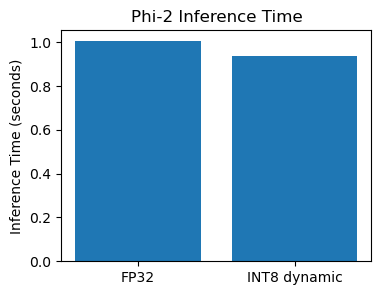

In [13]:
import matplotlib.pyplot as plt

# Create bar chart with training time results
plt.figure(figsize=(4,3))
plt.title("Phi-2 Inference Time")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "INT8 dynamic"], [fp32_inference_time, int8_inference_time])

In [14]:
print("[CODE_SAMPLE_COMPLETED_SUCCESFULLY]")

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
